In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/fasttext-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref/exparser/fasttext')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/exparser/fasttext/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/fasttext-300.matrix.npy',
                        text_columns = ['author', 'title', 'journal'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0906 11:22:58.771909  1832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 11:22:59.336687  1832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 11:23:28.692148  1832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 11:23:29.012961  1832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 11:23:29.012961  1832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 14


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0906 11:24:28.198585  1832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 11:24:28.247031  1832 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1841270 samples, validate on 230159 samples
Epoch 1/10
1841270/1841270 [==============================] - 225s 122us/step - loss: 0.2862 - acc: 0.8660 - val_loss: 0.0496 - val_acc: 0.9903
Epoch 2/10
1841270/1841270 [==============================] - 215s 117us/step - loss: 0.0377 - acc: 0.9901 - val_loss: 0.0244 - val_acc: 0.9903
Epoch 3/10
1841270/1841270 [==============================] - 213s 116us/step - loss: 0.0189 - acc: 0.9951 - val_loss: 0.0134 - val_acc: 0.9966
Epoch 4/10
1841270/1841270 [==============================] - 212s 115us/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0082 - val_acc: 0.9979
Epoch 5/10
1841270/1841270 [==============================] - 212s 115us/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0068 - val_acc: 0.9982
Epoch 6/10
1841270/1841270 [==============================] - 212s 115us/step - loss: 0.0069 - acc: 0.9982 - val_loss: 0.0064 - val_acc: 0.9984
Epoch 7/10
1841270/1841270 [==============================] - 212s 115us/step - los

# Learning curves

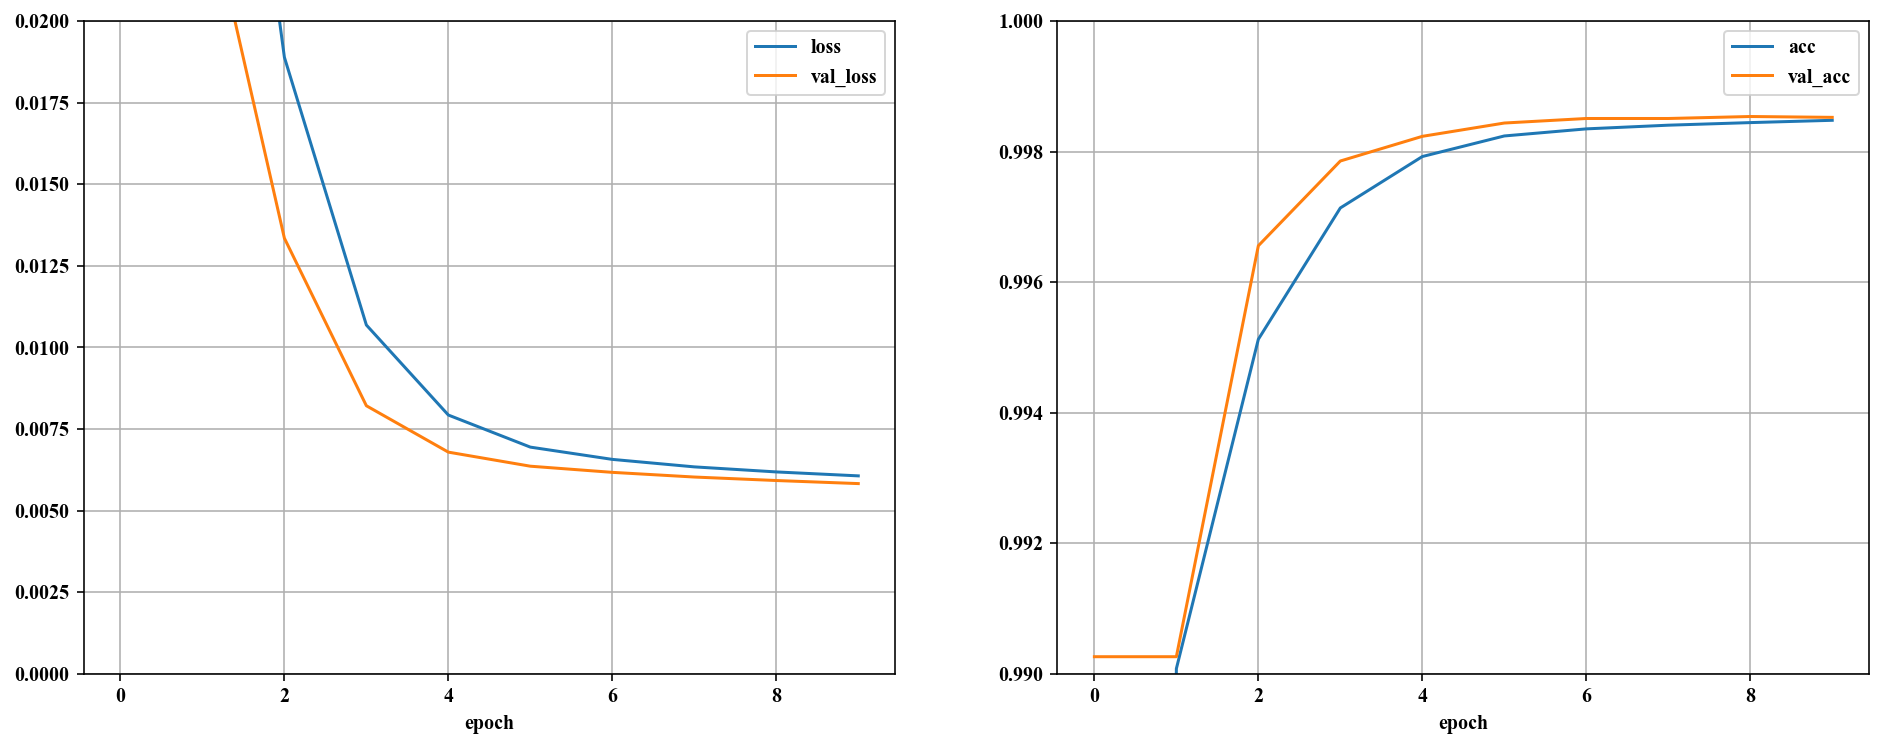

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227917
           1       0.97      0.88      0.92      2242

   micro avg       1.00      1.00      1.00    230159
   macro avg       0.98      0.94      0.96    230159
weighted avg       1.00      1.00      1.00    230159

[[227852     65]
 [   274   1968]]


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['author', 'title', 'journal']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,author,title,journal,year,id2,author,title,journal,year
62798,7e88e8e8-ac03-11e9-9154-04ea56df376a,<unk> Die <unk>,Reichardt C and Beispiele,<unk>,2002.0,7e89f99c-ac03-11e9-aba7-04ea56df376a,Beispiele <unk> die <unk>,C,<unk>,2002.0
210825,8b711652-ac03-11e9-ba4e-04ea56df376a,BCH <unk> 33 issue 2 Cover and Front matter,Anon,<unk>,2016.0,8b6fdea6-ac03-11e9-ae74-04ea56df376a,33 : 2 British,<unk>,<unk>,2016.0
64991,94119e12-ac03-11e9-aea6-04ea56df376a,<unk>,<unk> WL and Parent-Child <unk> F,<unk>,0.0,940fca94-ac03-11e9-8b43-04ea56df376a,<unk>,Warner W and Lloyd <unk> and <unk> F,<unk>,1937.0
66352,87e80f50-ac03-11e9-bb88-04ea56df376a,Early postoperative prediction of clinically relevant pancreatic fistula after pancreaticoduodenectomy,<unk> S and <unk> F and <unk> G,<unk>,0.0,87e6fe9a-ac03-11e9-b0a2-04ea56df376a,<unk> <unk> Prediction of Clinically Relevant Pancreatic Fistula after <unk> HPB 18 : E112,<unk> S,<unk>,2016.0
42317,7be621ae-ac03-11e9-846a-04ea56df376a,"<unk> , gianluca Sabbi , <unk> Shen <unk> Detection Utilizing Stray <unk>","Ravaioli Emmanuele , Maxim and Kai Zhang",<unk>,2018.0,7be73264-ac03-11e9-a531-04ea56df376a,Detection Utilizing Stray capacitances,Ravaioli E and <unk> M and Sabbi G and Shen T and Zhang K and Quench,<unk>,2018.0


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-exparser-fasttext.csv', index=False)
model.save_weights('../data/models/crossref-exparser-fasttext-base-1-num-null')

# Test model 

In [9]:
model.load_weights('../data/models/crossref-exparser-fasttext-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99883   0.99968   0.99925    227886
           1    0.96489   0.88253   0.92187      2273

   micro avg    0.99852   0.99852   0.99852    230159
   macro avg    0.98186   0.94111   0.96056    230159
weighted avg    0.99849   0.99852   0.99849    230159

[[227813     73]
 [   267   2006]]
